<a href="https://colab.research.google.com/github/sandorimrenagy/unimod-exp/blob/main/unimod_priming_behav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Unimod priming experiment data analysis***

- **version: pilot**
- **data: behavioral**

In [46]:
! ls

unimod_pilot_behav_df.csv  unimod_pilot_cleaned.csv  unimod_priming_behav.ipynb


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing dataframe**


In [48]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


!pip install pingouin

In [49]:
# importing df
filename = "/content/drive/MyDrive/Colab Notebooks/unimod_priming_data/unimod_pilot_behav_df.csv"

file_trial = pd.read_csv(filename, sep=";")

file_trial

,ID,trial_no,Code,Type,RT,RT Uncertainty,Time,Uncertainty,ReqTime
0,2,1,22124,miss,NaN,NaN,26519,1,4020
1,2,1,11232,hit,9589.0,2.0,83252,1,3250
2,2,1,11236,hit,11401.0,2.0,116786,1,1450
3,2,1,22211,miss,NaN,NaN,152390,1,1720
4,2,1,12242,hit,9929.0,2.0,210386,1,2210
...,...,...,...,...,...,...,...,...,...
1195,6,4,11218,hit,10129.0,2.0,2175034,1,1940
1196,6,4,12223,hit,8582.0,2.0,2210170,1,2580
1197,6,4,12142,hit,8226.0,2.0,2243633,1,2370
1198,6,4,21217,miss,NaN,NaN,2275455,1,1200


# **Preprocessing**

In [50]:
# verifying dataframe integrity
file_trial.info()
file_trial.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1200 non-null   int64  
 1   trial_no        1200 non-null   int64  
 2   Code            1200 non-null   int64  
 3   Type            1200 non-null   object 
 4   RT              913 non-null    float64
 5   RT Uncertainty  913 non-null    float64
 6   Time            1200 non-null   int64  
 7   Uncertainty     1200 non-null   int64  
 8   ReqTime         1200 non-null   int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 84.5+ KB


(1200, 9)

In [51]:
# converting "Code" and "trial_no" to "object" dtype
file_trial = file_trial.astype({"trial_no": object, "Code": "string"})

file_trial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1200 non-null   int64  
 1   trial_no        1200 non-null   object 
 2   Code            1200 non-null   string 
 3   Type            1200 non-null   object 
 4   RT              913 non-null    float64
 5   RT Uncertainty  913 non-null    float64
 6   Time            1200 non-null   int64  
 7   Uncertainty     1200 non-null   int64  
 8   ReqTime         1200 non-null   int64  
dtypes: float64(2), int64(4), object(2), string(1)
memory usage: 84.5+ KB


In [52]:
"""
Presentation threw an error message for the original "word_ccode"
concatenation ("ccode" + "word"). So it was truncated to "Code".
We need to convert it back to "ccode" and "word".

--> decoding "Code" to "ccode" and "wcode"

"""

file_trial['ccode'] = file_trial['Code'].str[:3]
file_trial['wcode'] = file_trial['Code'].str[3:]

file_trial2 = file_trial

file_trial2.head()

,ID,trial_no,Code,Type,RT,RT Uncertainty,Time,Uncertainty,ReqTime,ccode,wcode
0,2,1,22124,miss,NaN,NaN,26519,1,4020,221,24
1,2,1,11232,hit,9589.0,2.0,83252,1,3250,112,32
2,2,1,11236,hit,11401.0,2.0,116786,1,1450,112,36
3,2,1,22211,miss,NaN,NaN,152390,1,1720,222,11
4,2,1,12242,hit,9929.0,2.0,210386,1,2210,122,42


In [53]:
# defining pseudo-word and real-word based on first character of "ccode" by adding "w" or "p" to "wcode"--> "1" = real-word, "2" = pseudo-word

def decode(row):
  if row["ccode"][0] == "1":
    return "w" + row["wcode"]
  else:
    return "p" + row["wcode"]

file_trial['wcode'] = file_trial.apply(decode, axis=1)

file_trial.head()

,ID,trial_no,Code,Type,RT,RT Uncertainty,Time,Uncertainty,ReqTime,ccode,wcode
0,2,1,22124,miss,NaN,NaN,26519,1,4020,221,p24
1,2,1,11232,hit,9589.0,2.0,83252,1,3250,112,w32
2,2,1,11236,hit,11401.0,2.0,116786,1,1450,112,w36
3,2,1,22211,miss,NaN,NaN,152390,1,1720,222,p11
4,2,1,12242,hit,9929.0,2.0,210386,1,2210,122,w42


ccode:

first digit lexical status: 1- word, 2- pseudoword
second digit prosodic/stress Match/Mismatch: 1- Match, 2- Mismatch
third digit phonemic Match/Mismatch: 1- Match, 2- Mismatch

111- word, stress match, phoneme match, e.g. MON- MONster
112- word, stress match, phoneme mismatch, e.g. MON- DACkel
121- word, stress mismatch, phoneme match, e.g. mon- MONster
122- word, stress mismatch, phoneme mismatch, e.g. mon- DACkel

211- pseudoword, stress match, phoneme match, e.g. MON- MONste
212- pseudoword, stress match, phoneme mismatch, e.g. MON- DACke
221- pseudoword, stress mismatch, phoneme match, e.g. mon- MONste
222- pseudoword, stress mismatch, phoneme mismatch, e.g. mon- DACke

In [54]:
# creating "condition" column from "ccode" to make it easier to analyse and interpret

condition_labels = {
    "111": "word, stress match, phoneme match",
    "112": "word, stress match, phoneme mismatch",
    "121": "word, stress mismatch, phoneme match",
    "122": "word, stress mismatch, phoneme mismatch",
    "211": "pseudoword, stress match, phoneme match",
    "212": "pseudoword, stress match, phoneme mismatch",
    "221": "pseudoword, stress mismatch, phoneme match",
    "222": "pseudoword, stress mismatch, phoneme mismatch"
    }


def condition_col(row):
  return condition_labels[row["ccode"]]

file_trial["condition"] = file_trial.apply(condition_col, axis=1)

file_trial.head()

,ID,trial_no,Code,Type,RT,RT Uncertainty,Time,Uncertainty,ReqTime,ccode,wcode,condition
0,2,1,22124,miss,NaN,NaN,26519,1,4020,221,p24,"pseudoword, stress mismatch, phoneme match"
1,2,1,11232,hit,9589.0,2.0,83252,1,3250,112,w32,"word, stress match, phoneme mismatch"
2,2,1,11236,hit,11401.0,2.0,116786,1,1450,112,w36,"word, stress match, phoneme mismatch"
3,2,1,22211,miss,NaN,NaN,152390,1,1720,222,p11,"pseudoword, stress mismatch, phoneme mismatch"
4,2,1,12242,hit,9929.0,2.0,210386,1,2210,122,w42,"word, stress mismatch, phoneme mismatch"


In [55]:
# saving file
unimod_pilot_cleaned = file_trial

unimod_pilot_cleaned.to_csv("unimod_pilot_cleaned.csv", index=False)

# **Analysis**

***responses***


In [56]:
! ls

%cd /content/drive/MyDrive/Colab Notebooks/unimod_priming_data/

! ls

unimod_pilot_behav_df.csv  unimod_pilot_cleaned.csv  unimod_priming_behav.ipynb
/content/drive/MyDrive/Colab Notebooks/unimod_priming_data
unimod_pilot_behav_df.csv  unimod_pilot_cleaned.csv  unimod_priming_behav.ipynb


In [57]:
# import cleaned file for analysis
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/unimod_priming_data/unimod_pilot_cleaned.csv", sep=",")

df

,ID,trial_no,Code,Type,RT,RT Uncertainty,Time,Uncertainty,ReqTime,ccode,wcode,condition
0,2,1,22124,miss,NaN,NaN,26519,1,4020,221,p24,"pseudoword, stress mismatch, phoneme match"
1,2,1,11232,hit,9589.0,2.0,83252,1,3250,112,w32,"word, stress match, phoneme mismatch"
2,2,1,11236,hit,11401.0,2.0,116786,1,1450,112,w36,"word, stress match, phoneme mismatch"
3,2,1,22211,miss,NaN,NaN,152390,1,1720,222,p11,"pseudoword, stress mismatch, phoneme mismatch"
4,2,1,12242,hit,9929.0,2.0,210386,1,2210,122,w42,"word, stress mismatch, phoneme mismatch"
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,6,4,11218,hit,10129.0,2.0,2175034,1,1940,112,w18,"word, stress match, phoneme mismatch"
1196,6,4,12223,hit,8582.0,2.0,2210170,1,2580,122,w23,"word, stress mismatch, phoneme mismatch"
1197,6,4,12142,hit,8226.0,2.0,2243633,1,2370,121,w42,"word, stress mismatch, phoneme match"
1198,6,4,21217,miss,NaN,NaN,2275455,1,1200,212,p17,"pseudoword, stress match, phoneme mismatch"


In [58]:
# converting dataypes
df.info()
df = df.astype({"ccode": "string", "wcode": "string"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1200 non-null   int64  
 1   trial_no        1200 non-null   int64  
 2   Code            1200 non-null   int64  
 3   Type            1200 non-null   object 
 4   RT              913 non-null    float64
 5   RT Uncertainty  913 non-null    float64
 6   Time            1200 non-null   int64  
 7   Uncertainty     1200 non-null   int64  
 8   ReqTime         1200 non-null   int64  
 9   ccode           1200 non-null   int64  
 10  wcode           1200 non-null   object 
 11  condition       1200 non-null   object 
dtypes: float64(2), int64(7), object(3)
memory usage: 112.6+ KB


In [59]:
# response analysis
## filtering for used cols
response_data = df[["ID", "Type", "ccode", "wcode", "condition"]]

## counting "Type" proportions
response_freq = response_data["Type"].value_counts(normalize=True)
response_freq

hit          0.740000
miss         0.239167
incorrect    0.020833
Name: Type, dtype: float64

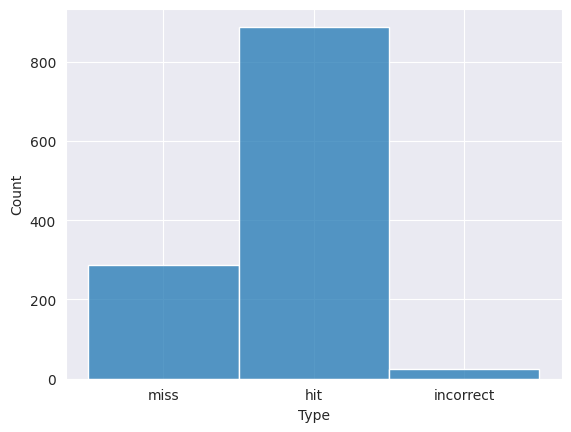

In [60]:
# plotting frequencies
sns.histplot(data=response_data["Type"])
plt.show()

In [61]:
# frequency table
freq_table = pd.crosstab(response_data["condition"], response_data["Type"], margins = True)
freq_table

Type,hit,incorrect,miss,All
condition,,,,
"pseudoword, stress match, phoneme match",0,12,63,75
"pseudoword, stress match, phoneme mismatch",0,6,69,75
"pseudoword, stress mismatch, phoneme match",0,2,73,75
"pseudoword, stress mismatch, phoneme mismatch",0,5,70,75
"word, stress match, phoneme match",224,0,1,225
"word, stress match, phoneme mismatch",220,0,5,225
"word, stress mismatch, phoneme match",222,0,3,225
"word, stress mismatch, phoneme mismatch",222,0,3,225
All,888,25,287,1200


It is difficult to interpert the response values in this form.
  Since this was a Go/No-Go task, participants had to press a button when they heard a real word, and did not press anything when heard a pseudo-word.
  In the case of real words (when particpant should have pressed the button), Presentation coded the button press as a "hit" (true positive) and not pressing it as a "miss" (false negative).
  In the case of pseudo-words (when particpant should not have pressed anything), however, the correct answer was coded as a "miss" (true negative) and the false button press as "incorrect" (false positive).
  That's why there are no pseudo-word "miss" and real word "incorrect" responses.

I advise to recode both real and pseudo-word responses to "correct" and "incorrect" values.

In [62]:
# creating new column: "response"

def decode_response(row):
    if row["wcode"][0] == "w" and row["Type"] == "miss":
        return "incorrect"
    elif row["wcode"][0] == "w" and row["Type"] == "hit":
        return "correct"
    elif row["wcode"][0] == "p" and row["Type"] == "miss":
        return "correct"
    else:
        return "incorrect"

response_data["response"] = response_data.apply(decode_response, axis=1)

response_data.head(10)

<ipython-input-62-4cd773e914b2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response_data["response"] = response_data.apply(decode_response, axis=1)


,ID,Type,ccode,wcode,condition,response
0,2,miss,221,p24,"pseudoword, stress mismatch, phoneme match",correct
1,2,hit,112,w32,"word, stress match, phoneme mismatch",correct
2,2,hit,112,w36,"word, stress match, phoneme mismatch",correct
3,2,miss,222,p11,"pseudoword, stress mismatch, phoneme mismatch",correct
4,2,hit,122,w42,"word, stress mismatch, phoneme mismatch",correct
5,2,hit,111,w08,"word, stress match, phoneme match",correct
6,2,hit,111,w15,"word, stress match, phoneme match",correct
7,2,hit,111,w03,"word, stress match, phoneme match",correct
8,2,hit,122,w24,"word, stress mismatch, phoneme mismatch",correct
9,2,hit,112,w07,"word, stress match, phoneme mismatch",correct


In [63]:
freq_table2 = pd.crosstab(response_data["condition"], response_data["response"], margins = True)
freq_table2

response,correct,incorrect,All
condition,,,
"pseudoword, stress match, phoneme match",63,12,75
"pseudoword, stress match, phoneme mismatch",69,6,75
"pseudoword, stress mismatch, phoneme match",73,2,75
"pseudoword, stress mismatch, phoneme mismatch",70,5,75
"word, stress match, phoneme match",224,1,225
"word, stress match, phoneme mismatch",220,5,225
"word, stress mismatch, phoneme match",222,3,225
"word, stress mismatch, phoneme mismatch",222,3,225
All,1163,37,1200


In [64]:
# frequency proportions
prop_data = response_data.groupby("condition")["response"].value_counts(normalize=True)
print(prop_data)

condition                                      response 
pseudoword, stress match, phoneme match        correct      0.840000
                                               incorrect    0.160000
pseudoword, stress match, phoneme mismatch     correct      0.920000
                                               incorrect    0.080000
pseudoword, stress mismatch, phoneme match     correct      0.973333
                                               incorrect    0.026667
pseudoword, stress mismatch, phoneme mismatch  correct      0.933333
                                               incorrect    0.066667
word, stress match, phoneme match              correct      0.995556
                                               incorrect    0.004444
word, stress match, phoneme mismatch           correct      0.977778
                                               incorrect    0.022222
word, stress mismatch, phoneme match           correct      0.986667
                                              

In [65]:
# creating two contingency tables, one for pseudowords and one for real words
response_pseudo = response_data[response_data['wcode'].str.startswith('p')]
response_pseudo_ct = pd.crosstab(response_pseudo["condition"],
                                 response_pseudo["response"],
                                 margins=True)
print(response_pseudo_ct)

response_word = response_data[response_data["wcode"].str.startswith("w")]
response_word_ct = pd.crosstab(response_word["condition"],
                                 response_word["response"],
                                 margins=True)

print(response_word_ct)

response                                       correct  incorrect  All
condition                                                             
pseudoword, stress match, phoneme match             63         12   75
pseudoword, stress match, phoneme mismatch          69          6   75
pseudoword, stress mismatch, phoneme match          73          2   75
pseudoword, stress mismatch, phoneme mismatch       70          5   75
All                                                275         25  300
response                                 correct  incorrect  All
condition                                                       
word, stress match, phoneme match            224          1  225
word, stress match, phoneme mismatch         220          5  225
word, stress mismatch, phoneme match         222          3  225
word, stress mismatch, phoneme mismatch      222          3  225
All                                          888         12  900


In [66]:
# calculating error rates and ranges for Go (false negative) and NoGo trials (false positive)
# False Positive Rate (fpr) and False Negative Rate (fnr)
fpr = 25/300
fnr = 12/900

print(f"The error rate in Go trials is: {fnr:.2%}")
print(f"The error rate in NoGo trials is: {fpr:.2%}")

The error rate in Go trials is: 1.33%
The error rate in NoGo trials is: 8.33%


In [67]:
# transforming data back from crosstab for easier visualization
response_word_counts = response_word.groupby(by="condition")["response"].value_counts().unstack().reset_index()
response_pseudo_counts = response_pseudo.groupby(by="condition")["response"].value_counts().unstack().reset_index()
print(response_word_counts)
print(response_pseudo_counts)

response                                condition  correct  incorrect
0               word, stress match, phoneme match      224          1
1            word, stress match, phoneme mismatch      220          5
2            word, stress mismatch, phoneme match      222          3
3         word, stress mismatch, phoneme mismatch      222          3
response                                      condition  correct  incorrect
0               pseudoword, stress match, phoneme match       63         12
1            pseudoword, stress match, phoneme mismatch       69          6
2            pseudoword, stress mismatch, phoneme match       73          2
3         pseudoword, stress mismatch, phoneme mismatch       70          5


<ipython-input-68-5b8b226cf515>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(response_word_counts["condition"], rotation=90)
<ipython-input-68-5b8b226cf515>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(response_pseudo_counts["condition"], rotation=90)


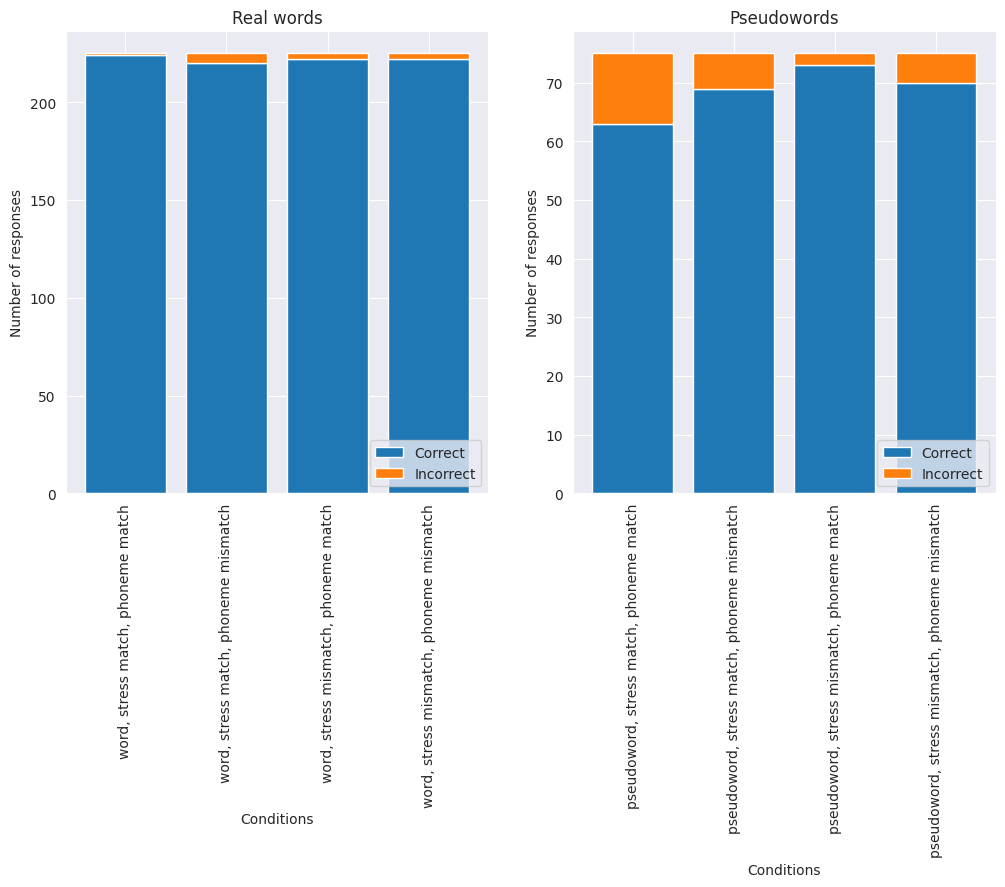

In [68]:
# creating barplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

## Create barplot1 on the left subplot
ax1.bar(response_word_counts["condition"], response_word_counts["correct"], label='Correct')
ax1.bar(response_word_counts["condition"], response_word_counts["incorrect"], bottom=response_word_counts["correct"], label='Incorrect')
ax1.set_xlabel('Conditions')
ax1.set_ylabel('Number of responses')
ax1.set_title('Real words')
ax1.legend(loc="lower right")

## Create barplot2 on the right subplot
ax2.bar(response_pseudo_counts["condition"], response_pseudo_counts["correct"], label='Correct')
ax2.bar(response_pseudo_counts["condition"], response_pseudo_counts["incorrect"], bottom=response_pseudo_counts["correct"], label='Incorrect')
ax2.set_xlabel('Conditions')
ax2.set_ylabel('Number of responses')
ax2.set_title('Pseudowords')
ax2.legend(loc="lower right")

ax1.set_xticklabels(response_word_counts["condition"], rotation=90)
ax2.set_xticklabels(response_pseudo_counts["condition"], rotation=90)

plt.show()

In [69]:
# Chi-squared test for independence (should I use Cochran's Q test instead
# to asses whether the proportion of successes is the same between conditions?)
stat, p, dof, expected = chi2_contingency(response_pseudo_ct)

print("Chi2 test for independence results for pseudowords:")
print(f"Chi-squared statistic: {stat}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected, "\n")

stat2, p2, dof2, expected2 = chi2_contingency(response_word_ct)

print("Chi2 test for independence results for real words:")
print(f"Chi-squared statistic: {stat2}")
print(f"P-value: {p2}")
print(f"Degrees of freedom: {dof2}")
print("Expected frequencies:")
print(expected2)

Chi2 test for independence results for pseudowords:
Chi-squared statistic: 9.207272727272727
P-value: 0.32511368503049315
Degrees of freedom: 8
Expected frequencies:
[[ 68.75   6.25  75.  ]
 [ 68.75   6.25  75.  ]
 [ 68.75   6.25  75.  ]
 [ 68.75   6.25  75.  ]
 [275.    25.   300.  ]] 

Chi2 test for independence results for real words:
Chi-squared statistic: 2.7027027027027026
P-value: 0.9516082357725064
Degrees of freedom: 8
Expected frequencies:
[[222.   3. 225.]
 [222.   3. 225.]
 [222.   3. 225.]
 [222.   3. 225.]
 [888.  12. 900.]]


In [70]:
# p > .05 --> there is no significant relationship between the conditions and the number of responses

# **Analysis**

***reaction times***

In [71]:
! ls

%cd /content/drive/MyDrive/Colab Notebooks/unimod_priming_data

! ls

unimod_pilot_behav_df.csv  unimod_pilot_cleaned.csv  unimod_priming_behav.ipynb
/content/drive/MyDrive/Colab Notebooks/unimod_priming_data
unimod_pilot_behav_df.csv  unimod_pilot_cleaned.csv  unimod_priming_behav.ipynb


In [72]:
# importing cleaned file for analysis
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/unimod_priming_data/unimod_pilot_cleaned.csv", sep=",")

df.head()

,ID,trial_no,Code,Type,RT,RT Uncertainty,Time,Uncertainty,ReqTime,ccode,wcode,condition
0,2,1,22124,miss,NaN,NaN,26519,1,4020,221,p24,"pseudoword, stress mismatch, phoneme match"
1,2,1,11232,hit,9589.0,2.0,83252,1,3250,112,w32,"word, stress match, phoneme mismatch"
2,2,1,11236,hit,11401.0,2.0,116786,1,1450,112,w36,"word, stress match, phoneme mismatch"
3,2,1,22211,miss,NaN,NaN,152390,1,1720,222,p11,"pseudoword, stress mismatch, phoneme mismatch"
4,2,1,12242,hit,9929.0,2.0,210386,1,2210,122,w42,"word, stress mismatch, phoneme mismatch"


In [73]:
# subsetting dataframe for analysis
df_reaction = df[["ID", "RT", "ccode", "wcode", "condition"]]
df_reaction.head()

,ID,RT,ccode,wcode,condition
0,2,NaN,221,p24,"pseudoword, stress mismatch, phoneme match"
1,2,9589.0,112,w32,"word, stress match, phoneme mismatch"
2,2,11401.0,112,w36,"word, stress match, phoneme mismatch"
3,2,NaN,222,p11,"pseudoword, stress mismatch, phoneme mismatch"
4,2,9929.0,122,w42,"word, stress mismatch, phoneme mismatch"


In [74]:
# transforming reaction time values to milliseconds
# (Neurobs Presentation logs time data in tenth of milliseconds)
df_reaction["RT"] = df_reaction["RT"]/10
df_reaction

<ipython-input-74-d1b29e165d9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reaction["RT"] = df_reaction["RT"]/10


,ID,RT,ccode,wcode,condition
0,2,NaN,221,p24,"pseudoword, stress mismatch, phoneme match"
1,2,958.9,112,w32,"word, stress match, phoneme mismatch"
2,2,1140.1,112,w36,"word, stress match, phoneme mismatch"
3,2,NaN,222,p11,"pseudoword, stress mismatch, phoneme mismatch"
4,2,992.9,122,w42,"word, stress mismatch, phoneme mismatch"
...,...,...,...,...,...
1195,6,1012.9,112,w18,"word, stress match, phoneme mismatch"
1196,6,858.2,122,w23,"word, stress mismatch, phoneme mismatch"
1197,6,822.6,121,w42,"word, stress mismatch, phoneme match"
1198,6,NaN,212,p17,"pseudoword, stress match, phoneme mismatch"


In [75]:
# subsetting for only words and dropping false negatives
reaction_time_words = df_reaction[df_reaction["wcode"].str.startswith("w")].dropna()
reaction_time_words.head()

,ID,RT,ccode,wcode,condition
1,2,958.9,112,w32,"word, stress match, phoneme mismatch"
2,2,1140.1,112,w36,"word, stress match, phoneme mismatch"
4,2,992.9,122,w42,"word, stress mismatch, phoneme mismatch"
5,2,1272.9,111,w08,"word, stress match, phoneme match"
6,2,1328.4,111,w15,"word, stress match, phoneme match"


In [76]:
# simplifying "condition" variable
reaction_time_words["condition"] = reaction_time_words["condition"].str.replace("word, ", "")
reaction_time_words["condition"] = reaction_time_words["condition"].str.replace(", ", " – ")

reaction_time_words.head(10)

,ID,RT,ccode,wcode,condition
1,2,958.9,112,w32,stress match – phoneme mismatch
2,2,1140.1,112,w36,stress match – phoneme mismatch
4,2,992.9,122,w42,stress mismatch – phoneme mismatch
5,2,1272.9,111,w08,stress match – phoneme match
6,2,1328.4,111,w15,stress match – phoneme match
7,2,1244.4,111,w03,stress match – phoneme match
8,2,911.3,122,w24,stress mismatch – phoneme mismatch
9,2,976.4,112,w07,stress match – phoneme mismatch
10,2,1213.2,121,w25,stress mismatch – phoneme match
11,2,944.1,112,w40,stress match – phoneme mismatch


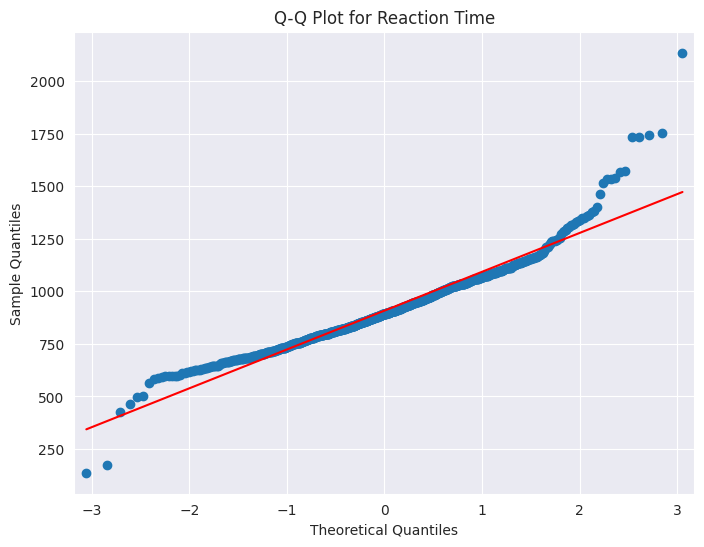

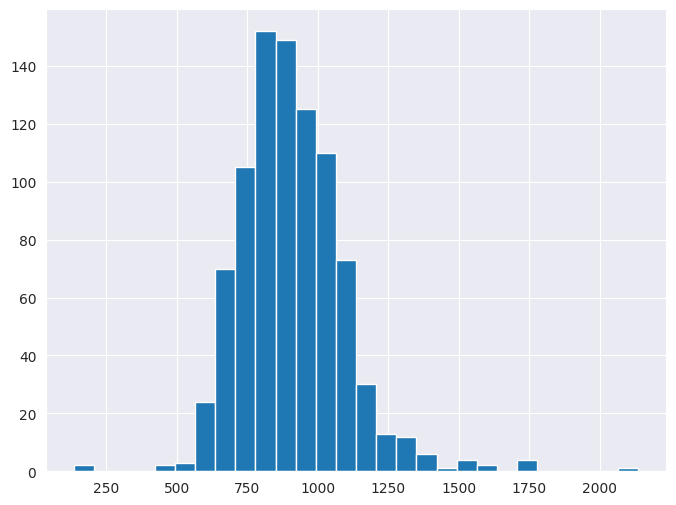

In [77]:
# creating a Q-Q plot
import statsmodels.api as sm

reaction_times = reaction_time_words["RT"]

fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(reaction_times, line='s', ax=ax)
ax.set_title('Q-Q Plot for Reaction Time')

fig2, ax2, = plt.subplots(figsize=(8,6))
reaction_times.hist(bins=28)
plt.show()

In [78]:
# Mauchly's test for sphericity
import pingouin as pg

mauchly_test = pg.sphericity(reaction_time_words, dv="RT", within="condition",
                             subject="ID", method="mauchly")
print(mauchly_test)

SpherResults(spher=True, W=0.45498951610802324, chi2=2.1436980105031256, dof=5, pval=0.8390918811081536)


In [79]:
# repeated measures ANOVA
aov = pg.rm_anova(data=reaction_time_words,
                  dv="RT",
                  within="condition",
                  subject="ID",
                  detailed=True)

# Display the ANOVA results
pg.print_table(aov, tablefmt="simple")


ANOVA SUMMARY

Source           SS    DF        MS        F    p-unc      ng2      eps
---------  --------  ----  --------  -------  -------  -------  -------
condition  4718.231     3  1572.744    5.116    0.017    0.047    0.655
Error      3688.929    12   307.411  nan      nan      nan      nan



In [80]:
# post hoc comparisons (Bonferroni corrected)
post_hocs = pg.pairwise_tests(data=reaction_time_words,
                              dv="RT",
                              within="condition",
                              subject="ID",
                              padjust="bonf",
                              effsize="cohen")

pg.print_table(post_hocs)
print("\t")

# checking with Tukey-test as well (Tukey HSD)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_results = pairwise_tukeyhsd(reaction_time_words["RT"], reaction_time_words["condition"])
print(tukey_results)


POST HOC TESTS

Contrast    A                                B                                   Paired    Parametric         T    dof  alternative      p-unc    p-corr  p-adjust      BF10    cohen
----------  -------------------------------  ----------------------------------  --------  ------------  ------  -----  -------------  -------  --------  ----------  ------  -------
condition   stress match – phoneme match     stress match – phoneme mismatch     True      True          -3.984  4.000  two-sided        0.016     0.098  bonf         4.945   -0.475
condition   stress match – phoneme match     stress mismatch – phoneme match     True      True          -1.168  4.000  two-sided        0.308     1.000  bonf         0.647   -0.150
condition   stress match – phoneme match     stress mismatch – phoneme mismatch  True      True          -3.401  4.000  two-sided        0.027     0.164  bonf         3.423   -0.458
condition   stress match – phoneme mismatch  stress mismatch – phoneme ma

ANOVA results: We found no significant differences in reaction times between conditions

In [81]:
# 2nd ANOVA analysis using a 2X2 model this time - creating new condition columns: "stress", "phoneme"
reaction_time_condition = reaction_time_words
reaction_time_condition[["stress", "phoneme"]] = reaction_time_condition["condition"].str.split(" – ", expand=True)

reaction_time_condition.head()

,ID,RT,ccode,wcode,condition,stress,phoneme
1,2,958.9,112,w32,stress match – phoneme mismatch,stress match,phoneme mismatch
2,2,1140.1,112,w36,stress match – phoneme mismatch,stress match,phoneme mismatch
4,2,992.9,122,w42,stress mismatch – phoneme mismatch,stress mismatch,phoneme mismatch
5,2,1272.9,111,w08,stress match – phoneme match,stress match,phoneme match
6,2,1328.4,111,w15,stress match – phoneme match,stress match,phoneme match


In [82]:
# 2nd ANOVA analysis using a 2X2 model this time -  two-way repeated measures ANOVA (two factors: "stress", "phoneme", dependent variable="RT")
aov2 = pg.rm_anova(data=reaction_time_condition,
                   dv="RT",
                   within=["stress", "phoneme"],
                   subject="ID",
                   detailed=True)

# Display the ANOVA results
pg.print_table(aov2, tablefmt="simple")


ANOVA SUMMARY

Source                  SS    ddof1    ddof2        MS       F    p-unc    p-GG-corr    ng2    eps
----------------  --------  -------  -------  --------  ------  -------  -----------  -----  -----
stress             188.184        1        4   188.184   0.331    0.596        0.596  0.002  1.000
phoneme           4325.224        1        4  4325.224  18.433    0.013        0.013  0.043  1.000
stress * phoneme   204.823        1        4   204.823   1.716    0.260        0.260  0.002  1.000



In [83]:
# 2nd ANOVA post-hoc tests
post_hocs2 = pg.pairwise_tests(data=reaction_time_condition,
                              dv="RT",
                              within=["stress", "phoneme"],
                              subject="ID",
                              padjust="bonf",
                              effsize="cohen")

pg.print_table(post_hocs2)


POST HOC TESTS

Contrast          stress           A              B                 Paired    Parametric         T    dof  alternative      p-unc    p-corr  p-adjust      BF10    cohen
----------------  ---------------  -------------  ----------------  --------  ------------  ------  -----  -------------  -------  --------  ----------  ------  -------
stress            -                stress match   stress mismatch   True      True          -0.575  4.000  two-sided        0.596   nan      nan          0.454   -0.080
phoneme           -                phoneme match  phoneme mismatch  True      True          -4.293  4.000  two-sided        0.013   nan      nan          5.927   -0.386
stress * phoneme  stress match     phoneme match  phoneme mismatch  True      True          -3.984  4.000  two-sided        0.016     0.033  bonf         4.945   -0.475
stress * phoneme  stress mismatch  phoneme match  phoneme mismatch  True      True          -2.951  4.000  two-sided        0.042     0.08

/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


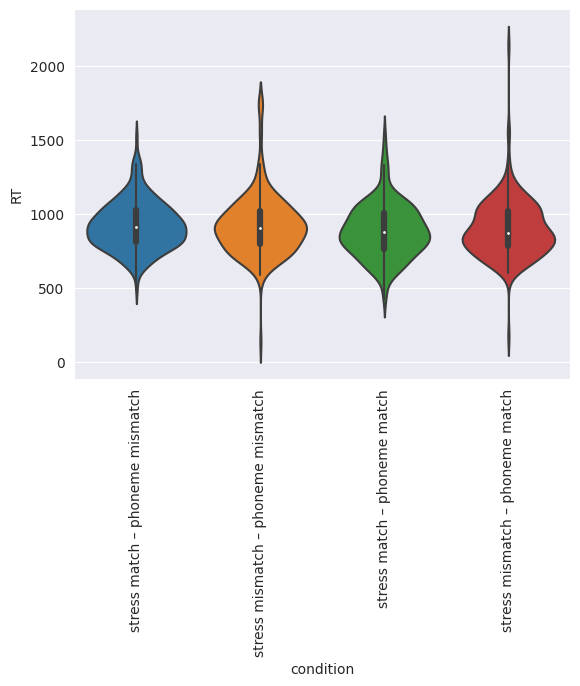


 condition
stress match – phoneme match          886.512946
stress match – phoneme mismatch       922.979091
stress mismatch – phoneme match       899.937387
stress mismatch – phoneme mismatch    923.030180
Name: RT, dtype: float64


In [84]:
# creating violinplots
sns.set_style("darkgrid")
ax = sns.violinplot(x="condition", y="RT",
               data=reaction_time_words,
               inner="box")

plt.xticks(rotation=90)
plt.show()

means=reaction_time_words.groupby(by="condition")["RT"].mean()
print("\n", means)

# Conclusions

We found no difference in the responses between conditions
We found no difference in reaction times between conditions

Since this was a pilot study, participants' numbers were low (n=5), suggesting reanalyzing with a larger sample size.